In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

from transformers import RobertaTokenizer, T5ForConditionalGeneration

import torch

from tqdm import tqdm


import sys
import os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append('../../code/py_scripts')

from helper import get_d_j_c_data_loaders, to_device, get_device, plot_data

from pathlib import Path


## Initialize Globals and Model

In [2]:
# GLOBALS
device = get_device()
BEAM_SIZE = 5
MAX_SEQ_LEN = 256
SOURCE_LEN = 256
LEARNING_RATE = 5e-5
EPOCHS = 5
BATCH_SIZE = 64 # change depending on the GPU Colab gives you
VAL_STEP = 20

PRETRAINED_MODEL_PATH = "../../models/java2cs/"
NEW_MODEL_PATH = "../../models/new_trained/java2cs/"
Path(NEW_MODEL_PATH).mkdir(parents=True, exist_ok=True)

dataset_path = "../../datasets/"

torch.cuda.empty_cache()

In [3]:
token = RobertaTokenizer.from_pretrained("Salesforce/codet5-base")
train_dl , valid_dl, test_dl = get_d_j_c_data_loaders(BATCH_SIZE, token
, training_name='train.new.java'
, validation_name='valid.new.java'
, testing_name='test.new.java'
, shuffle_train_val=True)

In [4]:
class JavaToCSModel(torch.nn.Module):
    def __init__(self, tokenizer, model_path, seq_len):
        super(JavaToCSModel, self).__init__()
        self.tokenizer = tokenizer
        self.seq_len = seq_len
        self.java_to_cs = T5ForConditionalGeneration.from_pretrained(model_path)

    def forward(self, input_ids, attention_mask, labels):
        doc_out = self.java_to_cs(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        return doc_out.loss

    def generate_code(self, input_ids):
        gen = self.java_to_cs.generate(input_ids, max_length=self.seq_len)
        return [self.tokenizer.decode(entry, skip_special_tokens=True) for entry in gen]
    
    def save(self, path):
        torch.save(self.state_dict(), path + "JavaToCSModel.pkl")
        self.java_to_cs.save_pretrained(path)

## Train and validation model

In [5]:
@torch.no_grad()
def validate(model, val_load):
    outputs = [model(batch['j_ids'], batch['j_mask'], batch['cs_ids']).detach().cpu() for batch in val_load]
    return np.average(outputs)

In [6]:
def train(clf, opt, dl, val, val_step):
    local_loss = []
    val_loss = []
    for _ in tqdm(range(EPOCHS)):
        for i, data in enumerate(dl):
            mod_out = clf(data['j_ids'], data['j_mask'], data['cs_ids'])
            local_loss.append(mod_out.detach().cpu())
            
            clf.zero_grad()
            mod_out.backward()
            opt.step()

            if i % val_step == 0 and i != 0:
                val_loss.append(validate(clf, val))
        
        print(f"Average Training loss = {np.average(local_loss)}")
        print(f"Average Validation loss = {np.average(val_loss)}")
        
    return local_loss, val_loss

In [7]:
model = to_device(JavaToCSModel(token, PRETRAINED_MODEL_PATH, MAX_SEQ_LEN), device)
rob_optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [8]:
t_loss, v_loss = train(model, rob_optimizer, train_dl, valid_dl, VAL_STEP)

 20%|██        | 1/5 [01:52<07:29, 112.50s/it]

Average Training loss = 0.040832873433828354
Average Validation loss = 0.062182310968637466


 40%|████      | 2/5 [03:35<05:19, 106.65s/it]

Average Training loss = 0.032162342220544815
Average Validation loss = 0.0596870481967926


 60%|██████    | 3/5 [05:18<03:30, 105.17s/it]

Average Training loss = 0.026164723560214043
Average Validation loss = 0.05967339500784874


 80%|████████  | 4/5 [07:03<01:45, 105.20s/it]

Average Training loss = 0.02188689447939396
Average Validation loss = 0.06031966954469681


100%|██████████| 5/5 [08:45<00:00, 105.17s/it]

Average Training loss = 0.018795911222696304
Average Validation loss = 0.061095334589481354


## Save Model

In [9]:
model.save(NEW_MODEL_PATH)

Ls:  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 2

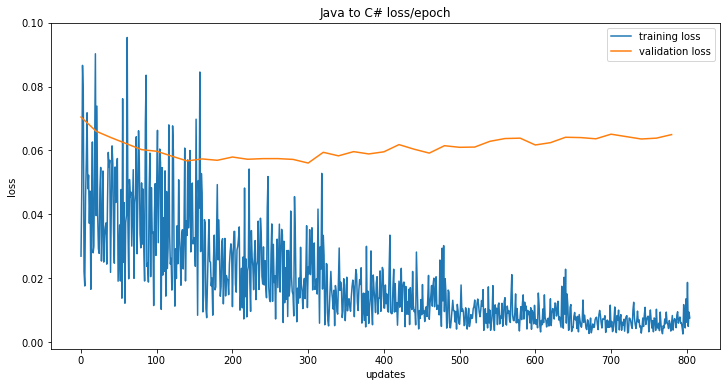

In [10]:
plot_data((t_loss, v_loss ), ('training loss', 'validation loss'), (len(t_loss), len(v_loss) )  , (1, VAL_STEP) , 'updates' , 'loss' , 'Java to C# loss/epoch')

In [11]:
@torch.no_grad()
def sample(clf, dl):
    sent_data = []
    for data in tqdm(dl):
        with torch.no_grad():
            sent_data += clf.generate_code(data['doc_ids'])
        
    return sent_data

In [12]:
doc_data = [sample(model, dl) for dl in (train_dl, valid_dl, test_dl)]

100%|██████████| 16/16 [01:10<00:00,  4.42s/it]


In [13]:

for name, d_data in zip(('train.new.cs', 'valid.new.cs' , 'test.new.cs'), tuple(doc_data)):
    with open(dataset_path + name, 'w') as f:
        for item in d_data:
            f.write("%s\n" % item)

In [14]:
# Save shuffled original files
def save_shuffled(dl, file_name):
    shuffled = []
    for d in dl:
        shuffled += d['cs_unchanged']

    with open(file_name, 'w') as f:
        for item in shuffled:
            f.write("%s\n" % item)

In [15]:
save_shuffled(train_dl, dataset_path + "train.shuffled.cs")
save_shuffled(valid_dl, dataset_path + "valid.shuffled.cs")

In [16]:
torch.cuda.empty_cache()